# **SME0829 Aprendizado de Máquina - Trabalho prático**

### **Sistemas de recomendação de Filmes** 🎥
----
Amanda Caroline de Oliveira Pires - 12559090

Caique Figueiredo Freitas -

Fabiana Pereira de Sousa - 10820532

Guilherme Pedrilho Soares - 11800862

---

## **Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Carregamento e Informações da base**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
links = pd.read_csv('/content/drive/MyDrive/Trabalho SME0829 - Aprendizado de Máquina/Dados/links.csv')
movies = pd.read_csv('/content/drive/MyDrive/Trabalho SME0829 - Aprendizado de Máquina/Dados/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Trabalho SME0829 - Aprendizado de Máquina/Dados/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/Trabalho SME0829 - Aprendizado de Máquina/Dados/tags.csv')

Data Movies

Arquivo representa um filme e possui o seguinte formato:

```
movieId, title, genres
```




In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**Data ratings**:

Todas as avaliações estão contidas no arquivo ratings.csv. Cada linha deste arquivo após a linha do cabeçalho representa uma classificação de um filme por um usuário e possui o seguinte formato:


```
userId,movieId,avaliação,timestamp

```


As linhas dentro desse arquivo são ordenadas primeiro por userId e, em user, por movieId.

As avaliações são feitas em uma escala de 5 estrelas, com incrementos de meia estrela (0,5 estrelas - 5,0 estrelas).

In [ ]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
ratings = ratings.filter(items=['userId', 'movieId', 'rating'])

**Data tags:**
Todas as tags estão contidas no arquivo tags.csv. Cada linha deste arquivo após a linha do cabeçalho representa uma tag aplicada a um filme por um usuário e possui o seguinte formato:


```
userId,movieId,tag,timestamp
```


As linhas dentro desse arquivo são ordenadas primeiro por userId e, em user, por movieId.

Tags são metadados gerados pelo usuário sobre filmes. Cada tag é tipicamente uma única palavra ou frase curta. O significado, valor e propósito de uma tag específica é determinado por cada usuário.

In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# **Modelos**

## **Modelos de Classificação - Baseados em árvores de decisão**

Este modelo foi aplicado para lidar com dados textuais, usando avaliações e títulos de filmes como entrada. Seu objetivo era realizar a classificação dos filmes em diferentes gêneros, a fim de criar um sistema de recomendação. Os modelos analisaram características textuais dos filmes e previu a qual gênero cada um pertencia, permitindo a recomendação de filmes semelhantes aos usuários com base em seus interesses e preferências.

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


### Funções

In [ ]:
def remove_stopwords(text,lang,domain_stopwords=[]):

  stop_words = nltk.corpus.stopwords.words(lang) # lang='portuguese' or lang='english'

  s = str(text).lower() # tudo para caixa baixa
  table = str.maketrans({key: None for key in string.punctuation})
  s = s.translate(table) # remove pontuacao
  tokens = word_tokenize(s) #obtem tokens
  v = [i for i in tokens if not i in stop_words and not i in domain_stopwords and not i.isdigit()] # remove stopwords
  s = ""
  for token in v:
    s += token+" "
  return s.strip()


# stemming
def stemming(text,lang):

  stemmer = PorterStemmer() # stemming para ingles

  if lang=='portuguese':
    stemmer = nltk.stem.RSLPStemmer() # stemming para portuguese

  tokens = word_tokenize(text) #obtem tokens

  sentence_stem = ''
  doc_text_stems = [stemmer.stem(i) for i in tokens]
  for stem in doc_text_stems:
    sentence_stem += stem+" "

  return sentence_stem.strip()


def meu_tokenizador(doc, stop_words=nltk.corpus.stopwords.words('english'), stemmer=PorterStemmer()):
  tokens = remove_stopwords(doc,stop_words)
  return stemming(tokens,stemmer)


# obtendo a VSM com TFIDF
def compute_vsm_tfidf(dataset,lang,domain_stopwords=[]):

  d = []
  for index,row in dataset.iterrows():
    text = row['text'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)

  # Palavras comuns têm menos IDF
  # Palavras únicas têm alto IDF
  tfidf = TfidfVectorizer(max_features=5000)
  vectorized_data_train = tfidf.fit_transform(dataset['text'].values)
  tfidf.get_feature_names_out()

  vectorized_dataframe = pd.DataFrame(vectorized_data_train.toarray(), index=dataset['text'].index.tolist())


  return vectorized_dataframe

### Limpeza e Vizualizações

In [ ]:
tags = tags.filter(items=['userId', 'movieId', 'tag'])

In [ ]:
movies_df = pd.merge(tags, ratings, on=['userId','movieId'], how='left') # juntando os dataframes com leftjoin
movies_df = pd.merge(movies_df, movies, on='movieId', how='left')
movies_df.reset_index(inplace=True, drop=True)

movies_df['rating'] = movies_df['rating'].fillna(movies_df['rating'].mean())

# Remover a data da coluna "Filme"
movies_df['title'] = movies_df['title'].str.replace(r'\s\(\d{4}\)', '')

# Preparando uma variavel target a ser inserida em nosso modelo
movies_df['prim_genero'] = movies_df['genres'].str.split("|").str[0]

<ipython-input-7-863ea19c23c5>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_df['title'] = movies_df['title'].str.replace(r'\s\(\d{4}\)', '')


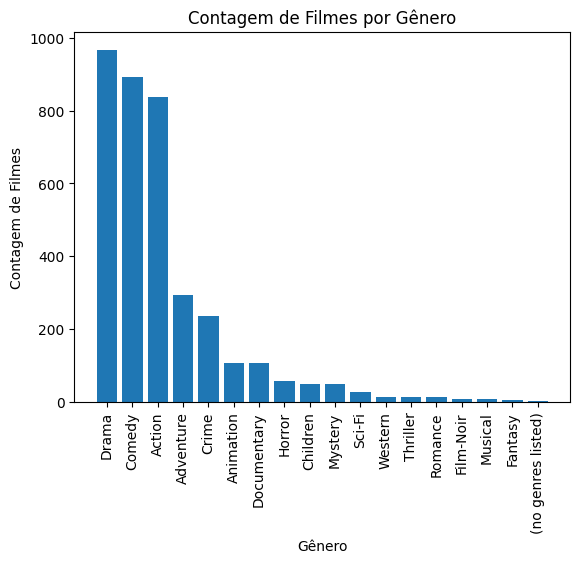

In [ ]:
grupo_generos = movies_df.groupby('prim_genero')['movieId'].count()
grupo_generos = grupo_generos.sort_values(ascending=False)
grupo_generos = grupo_generos.head(20)

# Criar o gráfico de barras
plt.bar(grupo_generos.index, grupo_generos.values)

# Definir rótulos e título do gráfico
plt.xlabel('Gênero')
plt.ylabel('Contagem de Filmes')
plt.title('Contagem de Filmes por Gênero')

# Rotacionar os rótulos no eixo x
plt.xticks(rotation=90)

# Exibir o gráfico
plt.show()

In [ ]:
# Excluir classes com apenas menor que 10 exemplos
value_counts = movies_df['prim_genero'].value_counts()
classes_to_remove = value_counts[value_counts < 10].index
movies_df = movies_df[~movies_df['prim_genero'].isin(classes_to_remove)]

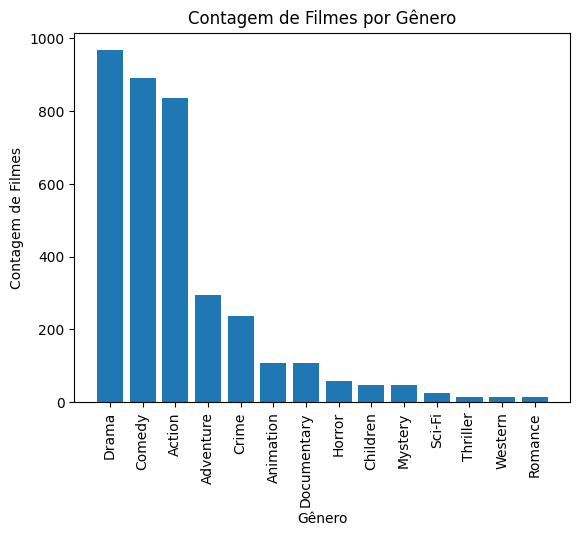

In [ ]:
grupo_generos = movies_df.groupby('prim_genero')['movieId'].count()
grupo_generos = grupo_generos.sort_values(ascending=False)
grupo_generos = grupo_generos.head(20)

# Criar o gráfico de barras
plt.bar(grupo_generos.index, grupo_generos.values)

# Definir rótulos e título do gráfico
plt.xlabel('Gênero')
plt.ylabel('Contagem de Filmes')
plt.title('Contagem de Filmes por Gênero')

# Rotacionar os rótulos no eixo x
plt.xticks(rotation=90)

# Exibir o gráfico
plt.show()

In [ ]:
df_modelo = movies_df.filter(items=['title', 'movieId', 'prim_genero', 'tag'])

In [ ]:
df_modelo['text'] = df_modelo['title'] + " " + df_modelo['tag']
df_modelo = df_modelo.filter(items=['movieId', 'prim_genero', 'text'])

### Separação em treino e teste

In [ ]:
lables = df_modelo['prim_genero'].to_list()

train_df, test_df, y_train, y_test = train_test_split(df_modelo, lables,test_size=0.30, random_state=42)

In [ ]:
train_df

,movieId,prim_genero,text
3630,2959,Action,Fight Club classic
328,135133,Adventure,The Hunger Games: Mockingjay - Part 2 Jennifer...
2913,1237,Drama,"Seventh Seal, The (Sjunde inseglet, Det) refle..."
3626,2959,Action,Fight Club based on a book
367,139385,Adventure,The Revenant survival
...,...,...,...
1130,522,Action,Romper Stomper Australia
1300,1135,Comedy,Private Benjamin military
860,4226,Mystery,Memento twist ending
3529,296,Comedy,Pulp Fiction sarcasm


Implementando a Ponderação de Termos com TFIDF para tratar os textos que serão nossa entrada pra o modelo.

### **Gradient Boosting Classifier**


O GradientBoostingClassifier é um modelo de aprendizado de máquina amplamente utilizado para problemas de classificação. Ele é construído a partir da combinação de múltiplos modelos de **árvore de decisão**, visando aprimorar a precisão das previsões. Esse algoritmo segue uma abordagem iterativa, em que cada árvore é treinada para corrigir os erros do modelo anterior, resultando em uma melhoria progressiva na performance.

Uma das principais vantagens do GradientBoostingClassifier é sua capacidade de lidar com conjuntos de dados complexos e de alta dimensionalidade.

In [ ]:
# Divisão dos dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(movies_df[['title', 'tag']], movies_df['prim_genero'], test_size=0.3, random_state=42)

In [ ]:
# Vetorização dos dados de texto
vectorizer = CountVectorizer()
X_train_title_tag = vectorizer.fit_transform(X_train['title'] + ' ' + X_train['tag'])
X_test_title_tag = vectorizer.transform(X_test['title'] + ' ' + X_test['tag'])

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_title_tag, y_train)

GradientBoostingClassifier()

In [ ]:
from sklearn.metrics import classification_report

y_pred = gbc.predict(X_test_title_tag)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.93      0.66      0.77       246
   Adventure       0.85      0.58      0.69        89
   Animation       0.84      0.78      0.81        27
    Children       0.77      0.56      0.65        18
      Comedy       0.87      0.60      0.71       282
       Crime       0.84      0.52      0.64        62
 Documentary       0.86      0.39      0.53        31
       Drama       0.51      0.92      0.66       292
      Horror       0.67      0.59      0.62        17
     Mystery       1.00      1.00      1.00        14
     Romance       0.50      0.50      0.50         2
      Sci-Fi       0.90      1.00      0.95         9
    Thriller       1.00      1.00      1.00         2
     Western       1.00      1.00      1.00         8

    accuracy                           0.70      1099
   macro avg       0.82      0.72      0.75      1099
weighted avg       0.78      0.70      0.71      1099



In [ ]:
import random

# Fazer a previsão do gênero para um filme de entrada
entrada = ['Shame (Skammen)']
X_entrada = vectorizer.transform(entrada)
genero_previsto = gbc.predict(X_entrada)[0]


# Filtrar os filmes do mesmo gênero
filmes_mesmo_genero = movies_df[movies_df['genres'] == genero_previsto]['title'].unique()

# Verificar se há pelo menos 10 filmes do mesmo gênero
if len(filmes_mesmo_genero) >= 10:
    random.shuffle(filmes_mesmo_genero)
    filmes_recomendados = filmes_mesmo_genero[:10]
else:
    filmes_recomendados = filmes_mesmo_genero

# Exibir os filmes do mesmo gênero
print(f'esses são os filmes recomendados para:{entrada[0]}')
print(filmes_recomendados)

esses são os filmes recomendados para:Shame (Skammen)
['Rudy' 'Birdman of Alcatraz' 'Come Back, Little Sheba'
 'Hands Over the City (Le mani sulla città)' 'Magnolia' 'Howards End'
 'Raise the Red Lantern (Da hong deng long gao gao gua)'
 'Miracle Worker, The' 'Magdalene Sisters, The' 'Quiz Show']


### **Decision Tree**


Uma árvore de decisão é um modelo de aprendizado de máquina que utiliza uma estrutura hierárquica de regras de decisão para realizar previsões ou tomar decisões. Cada nó interno da árvore representa um teste em uma determinada característica dos dados, enquanto os nós folha representam as classes ou valores de destino. Durante o processo de treinamento, a árvore de decisão é construída de forma iterativa, dividindo o conjunto de dados com base nas características que fornecem a melhor separação dos exemplos de treinamento.

Uma das principais vantagens das árvores de decisão é a sua interpretabilidade, pois as regras de decisão podem ser facilmente compreendidas e explicadas. Além disso, elas podem lidar com dados categóricos e numéricos, e também são capazes de lidar com problemas de classificação e regressão.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# Divisão dos dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(movies_df[['title', 'tag']], movies_df['prim_genero'], test_size=0.3, random_state=42)

# Vetorização dos dados de texto
vectorizer = CountVectorizer()
X_train_title_tag = vectorizer.fit_transform(X_train['title'] + ' ' + X_train['tag'])
X_test_title_tag = vectorizer.transform(X_test['title'] + ' ' + X_test['tag'])

# Criação e treinamento do modelo Decision Tree
dtc = DecisionTreeClassifier()
dtc.fit(X_train_title_tag, y_train)

# Fazer a previsão do gênero para um filme de entrada
entrada = ['Shame(Skammen)']
X_entrada = vectorizer.transform(entrada)
genero_previsto = dtc.predict(X_entrada)[0]

# Filtrar os filmes do mesmo gênero
filmes_mesmo_genero = movies_df[movies_df['genres'] == genero_previsto]['title'].unique()

# Verificar se há pelo menos 10 filmes do mesmo gênero
if len(filmes_mesmo_genero) >= 10:
    random.shuffle(filmes_mesmo_genero)
    filmes_recomendados = filmes_mesmo_genero[:10]
else:
    filmes_recomendados = filmes_mesmo_genero

# Exibir os filmes do mesmo gênero
print(f'esses são os filmes recomendados para:{entrada[0]}')
print(filmes_recomendados)

esses são os filmes recomendados para:Shame(Skammen)
["Mr. Holland's Opus" 'The Greatest Showman' 'Last Picture Show, The'
 'Cat on a Hot Tin Roof' 'Raging Bull' 'Pride of the Yankees, The'
 'Bad and the Beautiful, The' 'Midnight Cowboy' "Caveman's Valentine, The"
 "Gentleman's Agreement"]


In [ ]:
y_pred = dtc.predict(X_test_title_tag)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.89      0.77      0.83       246
   Adventure       0.76      0.66      0.71        89
   Animation       0.90      0.70      0.79        27
    Children       0.88      0.39      0.54        18
      Comedy       0.77      0.67      0.72       282
       Crime       0.73      0.56      0.64        62
 Documentary       0.77      0.32      0.45        31
       Drama       0.59      0.84      0.69       292
      Horror       0.71      0.71      0.71        17
     Mystery       0.81      0.93      0.87        14
     Romance       1.00      0.50      0.67         2
      Sci-Fi       1.00      1.00      1.00         9
    Thriller       0.67      1.00      0.80         2
     Western       1.00      0.88      0.93         8

    accuracy                           0.73      1099
   macro avg       0.82      0.71      0.74      1099
weighted avg       0.75      0.73      0.73      1099



### **Random Forest**

Random Forest é um algoritmo de aprendizado de máquina baseado em árvores de decisão que combina várias árvores individuais em um modelo único e robusto. Cada árvore é treinada em uma amostra aleatória dos dados de treinamento e, durante a previsão, a classificação final é determinada por meio de votação ou média das previsões de todas as árvores.
A Random Forest é amplamente utilizada devido à sua capacidade de lidar com problemas de classificação e regressão, fornecendo resultados confiáveis e de alta qualidade.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# Criação e treinamento do modelo Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train_title_tag, y_train)

# Fazer a previsão do gênero para um filme de entrada
entrada = ['Shame (Skammen)']
X_entrada = vectorizer.transform(entrada)
genero_previsto = rfc.predict(X_entrada)[0]

# Filtrar os filmes do mesmo gênero
filmes_mesmo_genero = movies_df[movies_df['genres'] == genero_previsto]['title'].unique()

# Verificar se há pelo menos 10 filmes do mesmo gênero

if len(filmes_mesmo_genero) >= 10:
    random.shuffle(filmes_mesmo_genero)
    filmes_recomendados = filmes_mesmo_genero[:10]
else:
    filmes_recomendados = filmes_mesmo_genero

# Filmes recomendados
print(f'esses são os filmes recomendados para:{entrada[0]}')

print(filmes_recomendados)

esses são os filmes recomendados para:Shame (Skammen)
["Sophie's Choice" 'Ray' 'Alive' 'Heaven' 'Mask'
 'Searching for Bobby Fischer' 'Blue Car'
 'Blue Angel, The (Blaue Engel, Der)' 'House of Sand and Fog'
 "Babette's Feast (Babettes gæstebud)"]


In [ ]:
y_pred = rfc.predict(X_test_title_tag)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.95      0.78      0.85       246
   Adventure       0.90      0.60      0.72        89
   Animation       0.82      0.85      0.84        27
    Children       0.83      0.56      0.67        18
      Comedy       0.89      0.64      0.74       282
       Crime       0.77      0.58      0.66        62
 Documentary       1.00      0.35      0.52        31
       Drama       0.55      0.93      0.70       292
      Horror       0.83      0.59      0.69        17
     Mystery       1.00      0.93      0.96        14
     Romance       0.50      0.50      0.50         2
      Sci-Fi       0.90      1.00      0.95         9
    Thriller       1.00      1.00      1.00         2
     Western       1.00      0.88      0.93         8

    accuracy                           0.75      1099
   macro avg       0.85      0.73      0.77      1099
weighted avg       0.81      0.75      0.75      1099



## Filtragem Colaborativa

Filtro colaborativo é uma técnica utilizada em sistemas de recomendação para prever as preferências ou interesses de um usuário com base nas opiniões e comportamentos de outros usuários. A ideia básica por trás do filtro colaborativo é que, se duas pessoas têm gostos ou interesses semelhantes em determinados itens (como filmes, músicas, produtos, etc.), é provável que a opinião de uma seja relevante para a outra.

Existem duas abordagens principais para implementar o filtro colaborativo: **filtragem colaborativa baseada em usuário** e **filtragem colaborativa baseada em item**.

Na **filtragem colaborativa baseada em usuário**, o sistema de recomendação procura usuários com gostos semelhantes ao usuário-alvo e utiliza as opiniões desses usuários para fazer recomendações. Por exemplo, se o usuário-alvo gostou de filmes A, B e C, e outro usuário que compartilha gostos semelhantes ao usuário-alvo também gostou dos filmes A e B, é provável que o usuário-alvo também goste do filme C.

Na **filtragem colaborativa baseada em item**, o sistema de recomendação procura itens semelhantes ao item desejado e utiliza as preferências dos usuários em relação a esses itens para fazer recomendações. Por exemplo, se o usuário-alvo gostou dos filmes A e B, e outros usuários que também gostaram dos filmes A e B também gostaram do filme C, é provável que o usuário-alvo também goste do filme C.

Ambas as abordagens têm suas vantagens e desvantagens, e existem várias técnicas e algoritmos específicos para implementar o filtro colaborativo em sistemas de recomendação. Essas técnicas podem incluir cálculos de similaridade entre usuários ou itens, técnicas de agrupamento, análise de vizinhança e algoritmos de aprendizado de máquina, como filtragem baseada em memória (Memory-based Filtering) e filtragem baseada em modelo (Model-based Filtering).

O filtro colaborativo é amplamente utilizado em sistemas de recomendação, especialmente em plataformas de comércio eletrônico, serviços de streaming de música e vídeo, e redes sociais, onde as recomendações personalizadas desempenham um papel importante na experiência do usuário.

### Imports e Leitura dos Dados

In [ ]:
!pip install surprise
import pandas as pd
import json
import math
import numpy as np

from surprise.model_selection import GridSearchCV, train_test_split
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.accuracy import mae, mse, rmse


reader = Reader(rating_scale=(0.5, 5))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/Trabalho SME0829 - Aprendizado de Máquina/Dados/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Trabalho SME0829 - Aprendizado de Máquina/Dados/ratings.csv')
display(ratings)
display(movies)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


### **Filtragem colaborativa baseada em usuário**
A ideia central da filtragem colaborativa baseada em usuário é que usuários com históricos de preferências semelhantes têm maior probabilidade de gostar dos mesmos itens. Portanto, o sistema de recomendação procura identificar usuários similares com base em suas interações passadas - nesse caso, notas atribuidas aos filmes.


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


Iremos utilizar o Grid Search para definir qual algoritmo de clusterização iremos utilizar, baseado no RMSE.

In [ ]:
for algo in [KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline]:

    param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
    gs = GridSearchCV(algo, param_grid, measures=["rmse", "mae"], cv=3)

    gs.fit(data)
    print(f"{str(algo)} rmse: ", gs.best_score["rmse"])

    print(f"{str(algo)} best params: ", gs.best_params["rmse"])


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi


Logo, é possível afimar que o *KNNBaseline* é o algoritmo com menor **RMSE**, com 0.88 e, portanto, será o que vamos utilizar.

Além disso, iremos utilizar a correlação de pearson para computar a similaridade entre as notas atribuidas pelos usuários, dada por:

$
\text{sim}(u_a, u_b) = \text{cor}(R^*_{u_a}, R^*_{u_b})
$,
onde $R^*_{u_a}$ é o vetor das notas atribuidas pelo usuário $u_a$ nos produtos avalidados em ambos $u_a$ e $u_b$

In [ ]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

sim_options = {
    "name": "pearson_baseline",
    "user_based": True
}
bsl_options = {
    "method": "sgd",
    "n_epochs": 5,
    "reg_u": 12,
    "reg_i": 5
}

knn_algorithm = KNNBaseline(
    k=20, min_k=5, sim_options=sim_options, bsl_options=bsl_options
)

trainset_full = data.build_full_trainset()
knn_algorithm.fit(trainset_full)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Primeiro, vamos tentar prever a nota dos filmes que o usuario de user id escolhido avaliou a partir da avaliação dos 20 vizinhos sobre o mesmo filme. Iremos utilizar o seguinte critério: só consideraremos os filmes em que pelo menos 30% dos vizinhos também avaliaram.

Supondo que queremos avaliar o usuário 212 e k = 20 (pode-se testar outros valores de k e user_id!)

In [ ]:
user_id = 222
k = 20

neighbors = knn_algorithm.get_neighbors(k=k, iid=user_id)

movies_rated_by_neighbors = ratings[ratings['userId'].isin(neighbors)].movieId.tolist()
movies_rated_by_user = list(set([
    movie_id for movie_id in movies_rated_by_neighbors
    if movie_id in ratings[ratings['userId'] == user_id].movieId.tolist()
]))


In [ ]:
predicted_aval = []
for movie_id in movies_rated_by_user:
    predicted_rating_sum = 0
    n_aval = 0
    for neighbor_id in neighbors:
        neighbor_rating = ratings[(ratings['userId'] == neighbor_id) & (ratings['movieId'] == movie_id)].rating.tolist()
        if neighbor_rating:
            n_aval += 1
            predicted_rating_sum += neighbor_rating[0]
    predicted_rating = predicted_rating_sum / n_aval
    if n_aval >= np.floor(0.30*len(neighbors)):
        predicted_aval.append((movie_id, predicted_rating))


In [ ]:
considered_movies = [i[0] for i in predicted_aval]

real_aval = ratings[(ratings['userId'] == user_id) & (ratings['movieId'].isin(considered_movies))]
display(real_aval)
sorted(predicted_aval, key=lambda x: x[0])

,userId,movieId,rating,timestamp
32594,222,50,3.0,1391346849
32601,222,293,3.0,1391350440
32602,222,296,4.0,1391350322
32605,222,356,4.0,1391350391
32622,222,858,4.5,1391346840
32630,222,1198,4.0,1391346897
32664,222,2028,3.0,1391350133
32669,222,2329,3.5,1391350381
32675,222,2571,4.0,1391350315
32680,222,2959,3.5,1391346893


[(50, 3.9375),
 (293, 4.166666666666667),
 (296, 4.666666666666667),
 (356, 4.333333333333333),
 (858, 4.0),
 (1198, 4.25),
 (2028, 4.333333333333333),
 (2329, 4.3125),
 (2571, 4.142857142857143),
 (2959, 4.111111111111111),
 (4993, 3.6875),
 (5952, 3.9285714285714284),
 (6874, 3.9166666666666665),
 (8961, 3.9166666666666665),
 (79132, 3.857142857142857)]

In [ ]:
def calculate_mae(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Input lists must have the same length.")

    n = len(list1)
    absolute_errors = [abs(list1[i] - list2[i]) for i in range(n)]
    mae = sum(absolute_errors) / n
    return mae

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Input lists must have the same length.")

    n = len(list1)
    squared_errors = [(list1[i] - list2[i])**2 for i in range(n)]
    mse = sum(squared_errors) / n
    rmse = math.sqrt(mse)
    return rmse


In [ ]:
real_aval = real_aval.sort_values(by='movieId').rating.tolist()
pred_aval = sorted(predicted_aval, key=lambda x: x[0])
pred_aval = [i[1] for i in pred_aval]

print("MSE: ", calculate_rmse(real_aval, pred_aval))
print("MAE: ", calculate_mae(real_aval, pred_aval))

MSE:  0.692626636308064
MAE:  0.5901455026455026


Agora, vamos prever avaliações para filmes que o usuário não avaliou, com base também nos vizinhos e só considerando filmes que pelo menos 30% dos vizinhos avaliaram.

Para estimar $R_{i, j}$, a nota que o usuário *i* daria para o filme *j*, caso o avaliasse,  calcula-se as médias das notas dadas pelos K vizinhos mais próximos, caso pelo menos 30% desses k vizinhos tenham avaliado o filme *j*

In [ ]:
movies_not_rated_by_user = list(set([
    movie_id for movie_id in movies_rated_by_neighbors
    if movie_id not in ratings[ratings['userId'] == user_id].movieId.tolist()
]))

recommendations = []
for movie_id in movies_not_rated_by_user:
    predicted_rating_sum = 0
    n_aval = 0
    for neighbor_id in neighbors:
        neighbor_rating = ratings[(ratings['userId'] == neighbor_id) & (ratings['movieId'] == movie_id)].rating.tolist()
        if neighbor_rating:
            n_aval += 1
            predicted_rating_sum += neighbor_rating[0]
    predicted_rating = predicted_rating_sum / n_aval
    if n_aval >= np.floor(0.3*len(neighbors)):
        recommendations.append((movie_id, predicted_rating))


In [ ]:
recommendations.sort(key=lambda x: x[1], reverse=True)

rated_movies = []
# Print the recommended movies
for movie_id, score in recommendations[:k]:
    print(movie_id, score)
    rated_movies.append(movie_id)

1196 4.833333333333333
260 4.583333333333333
1193 4.333333333333333
4226 4.25
318 4.2272727272727275
1 4.0
60069 4.0
4886 4.0
7153 3.8125
4306 3.7857142857142856
593 3.6875


Portanto, os filmes recomendados para o usuário *user_id* seguindo a lógica descrita acima são:

In [ ]:
ids = [x[0] for x in recommendations]
movies[movies['movieId'].isin(ids)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
896,1193,One Flew Over the Cuckoo's Nest (1975),Drama
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
3141,4226,Memento (2000),Mystery|Thriller
3194,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
4800,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


### **Filtragem colaborativa baseada em item**

Sistemas de recomendação com filtragem baseada em item são algoritmos utilizados para fornecer recomendações personalizadas aos usuários, com base nas características dos itens que eles utilizaram, visualizaram ou avaliaram anteriormente. Esses sistemas são amplamente utilizados em plataformas de comércio eletrônico, streaming de mídia, redes sociais e outras aplicações que requerem recomendações relevantes para os usuários.

A filtragem baseada em item utiliza informações sobre os itens disponíveis no sistema e a maneira como eles são avaliados ou relacionados pelos usuários para gerar recomendações. O princípio subjacente é que usuários que têm preferências semelhantes para um item também terão preferências semelhantes para outros itens relacionados.

Iremos utilizar o SVD para recomendar os filmes.

O modelo SVD é aplicado em uma matriz de avaliações, também conhecida como matriz de utilidade, que relaciona usuários e itens. Essa matriz é preenchida com avaliações dos usuários para os itens que eles utilizaram ou avaliaram. No entanto, a matriz geralmente é esparsa, ou seja, muitos valores estão faltando, pois um usuário avaliou apenas uma pequena fração de todos os itens disponíveis.




In [ ]:
# Queremos avaliar as predições para o usuário definido abaixo:

user_id = 222

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

preds = [pred for pred in predictions if pred.uid == user_id]

In [ ]:
predicoes_notas = ratings[(ratings.userId == user_id) & (ratings.movieId).isin([id.iid for id in preds])]

In [ ]:
mae(predictions)
mse(predictions)
rmse(predictions)

MAE:  0.6742
MSE: 0.7724
RMSE: 0.8789


0.8788589478462789

## **Agrupamento hierárquico**

Agrupamento Hierárquico é um método de análise de dados utilizado para agrupar objetos similares em clusters hierárquicos. Ele permite a criação de uma estrutura de agrupamento em forma de árvore, conhecida como dendrograma, que ilustra as relações de similaridade entre os objetos.\
\
A ideia básica do algoritmo que será implementado é agrupar os filmes de acordo com os gêneros aos quais ele pertence. Após isso, dado um usuário de interesse, estimaremos o seu grupo de filmes preferido de acordo com a nota média dada aos filmes assistidos.\
\
Por fim, sabendo o grupo preferido do usuário, podemos selecionar um filme que tenha sido bem avaliado nesse grupo e quem ainda não tenha sido assistido pelo usuário

### Imports

In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import metrics
import sys
from google.colab import drive
sys.setrecursionlimit(10000)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Leitura e tratamento dos dados

In [ ]:
df_movies = pd.read_csv('/content/drive/MyDrive/ML/movies.csv')
df_ratings = pd.read_csv('/content/drive/MyDrive/ML/ratings.csv')
user = 599  # Pode-se usar qualquer outro usuário

In [ ]:
# Investigando o dataframe de filmes
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Podemos usar a coluna genres para definir os gêneros de cada filme.\
Dessa forma, criaremos uma coluna para cada gênero e atribuiremos os valores 1 ou 0

In [ ]:
movies = df_movies.copy()
movies = pd.concat([movies, movies['genres'].str.get_dummies('|')], axis=1)
movies = movies.drop(['genres', 'title', '(no genres listed)'], axis=1)
movies = movies.set_index('movieId')
print(f'Temos ao todo {len(movies.columns)} gêneros de filmes.')
movies

Temos ao todo 19 gêneros de filmes.


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193583,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Clusterização

Vamos agrupar os filmes por similaridade de gênero testando diversas métricas para a distância entre os clusters

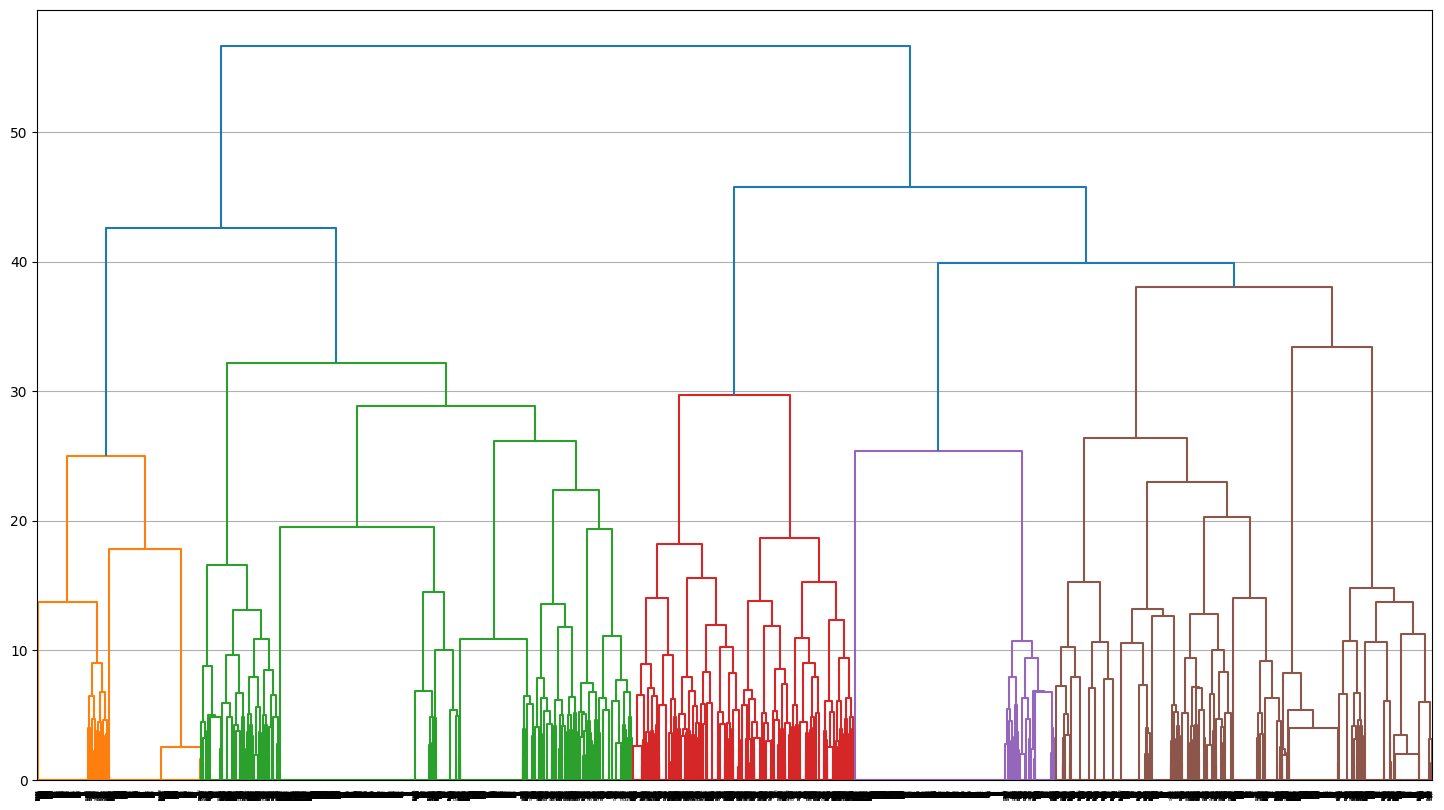

In [ ]:
Z = linkage(movies, 'ward')
plt.figure(figsize=(18, 10))
plt.grid(axis='y')
dn = dendrogram(Z, labels=list(movies.index), leaf_font_size=2)

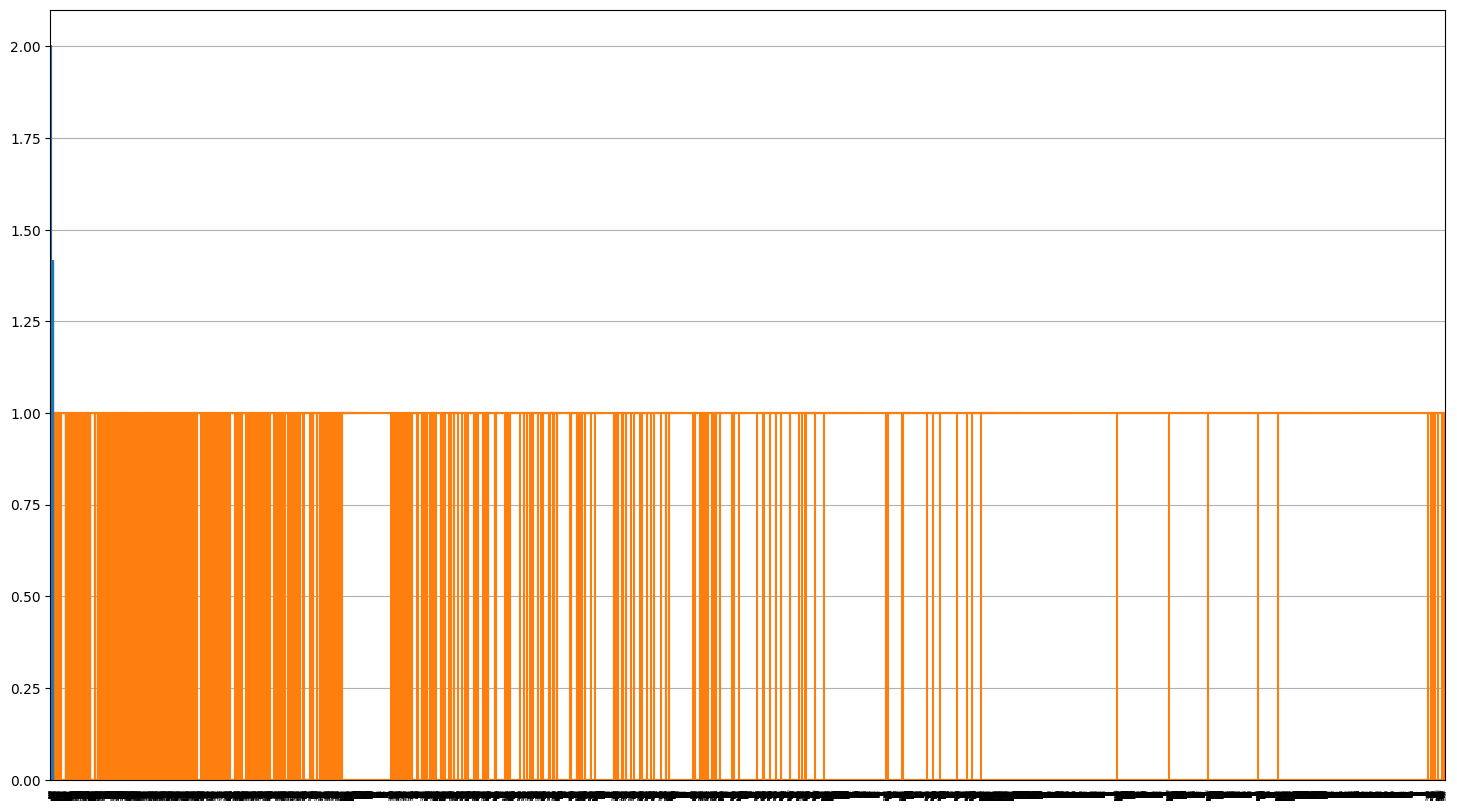

In [ ]:
Z = linkage(movies, 'single')
plt.figure(figsize=(18, 10))
plt.grid(axis='y')
dn = dendrogram(Z, labels=list(movies.index), leaf_font_size=2)

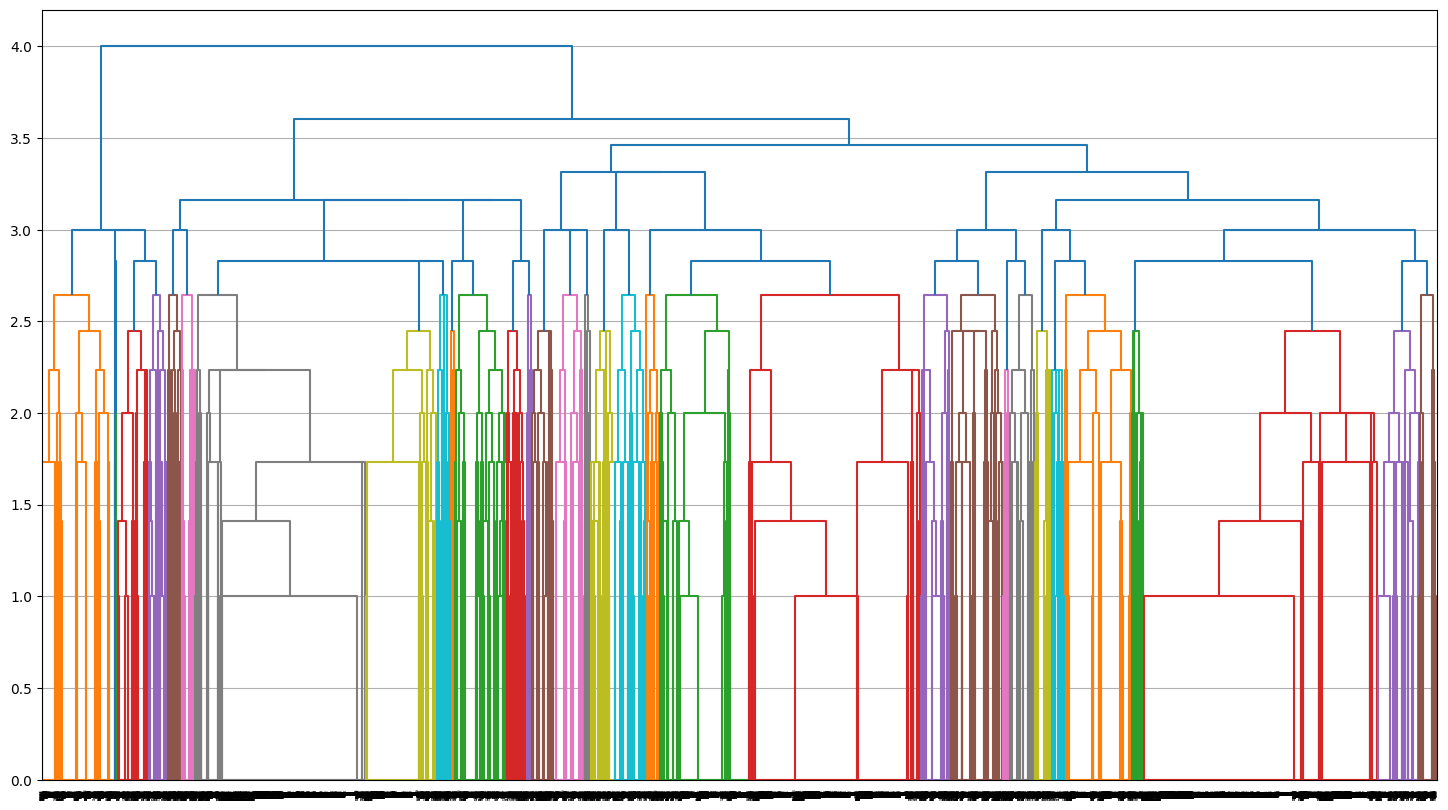

In [ ]:
Z = linkage(movies, 'complete')
plt.figure(figsize=(18, 10))
plt.grid(axis='y')
dn = dendrogram(Z, labels=list(movies.index), leaf_font_size=2)

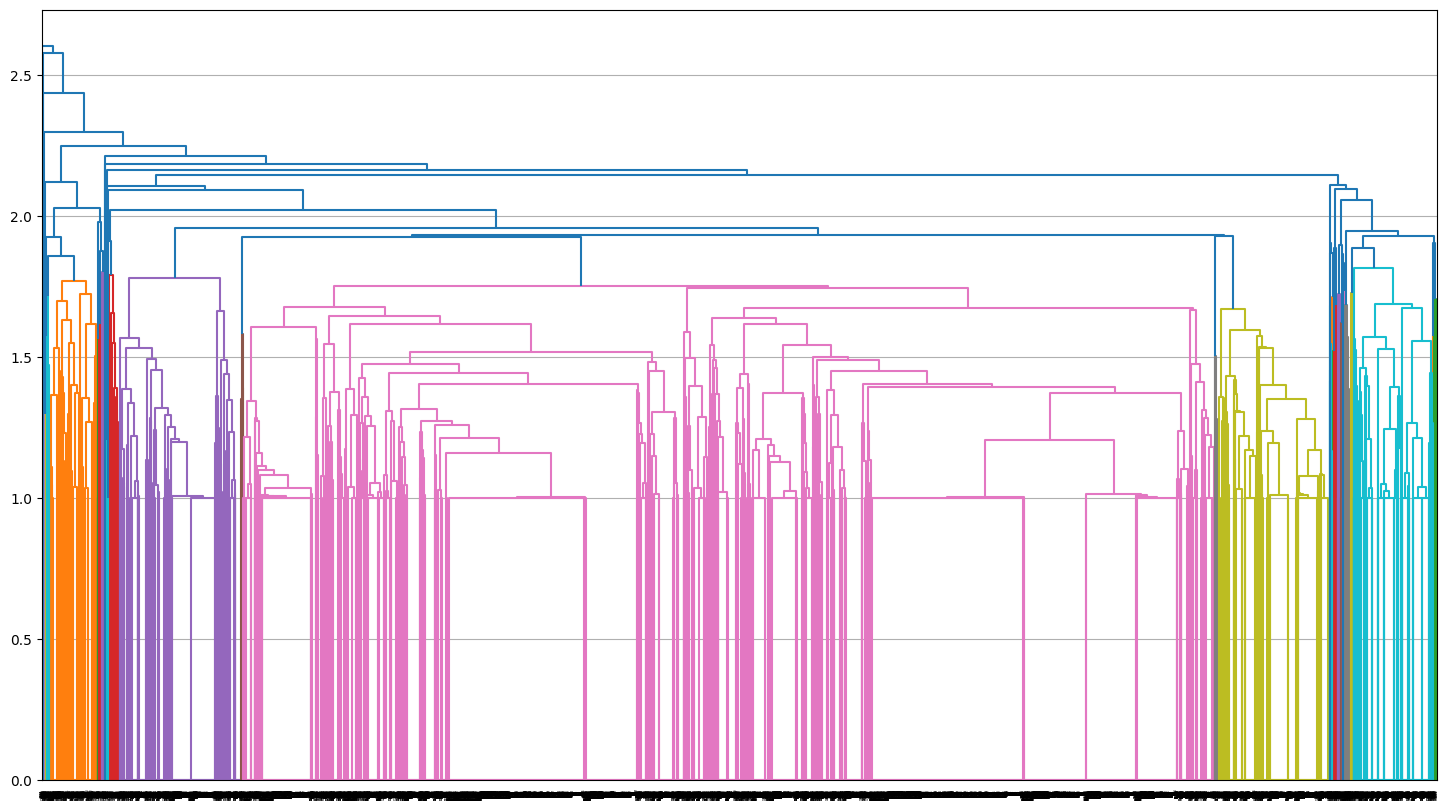

In [ ]:
Z = linkage(movies, 'average')
plt.figure(figsize=(18, 10))
plt.grid(axis='y')
dn = dendrogram(Z, labels=list(movies.index), leaf_font_size=2)

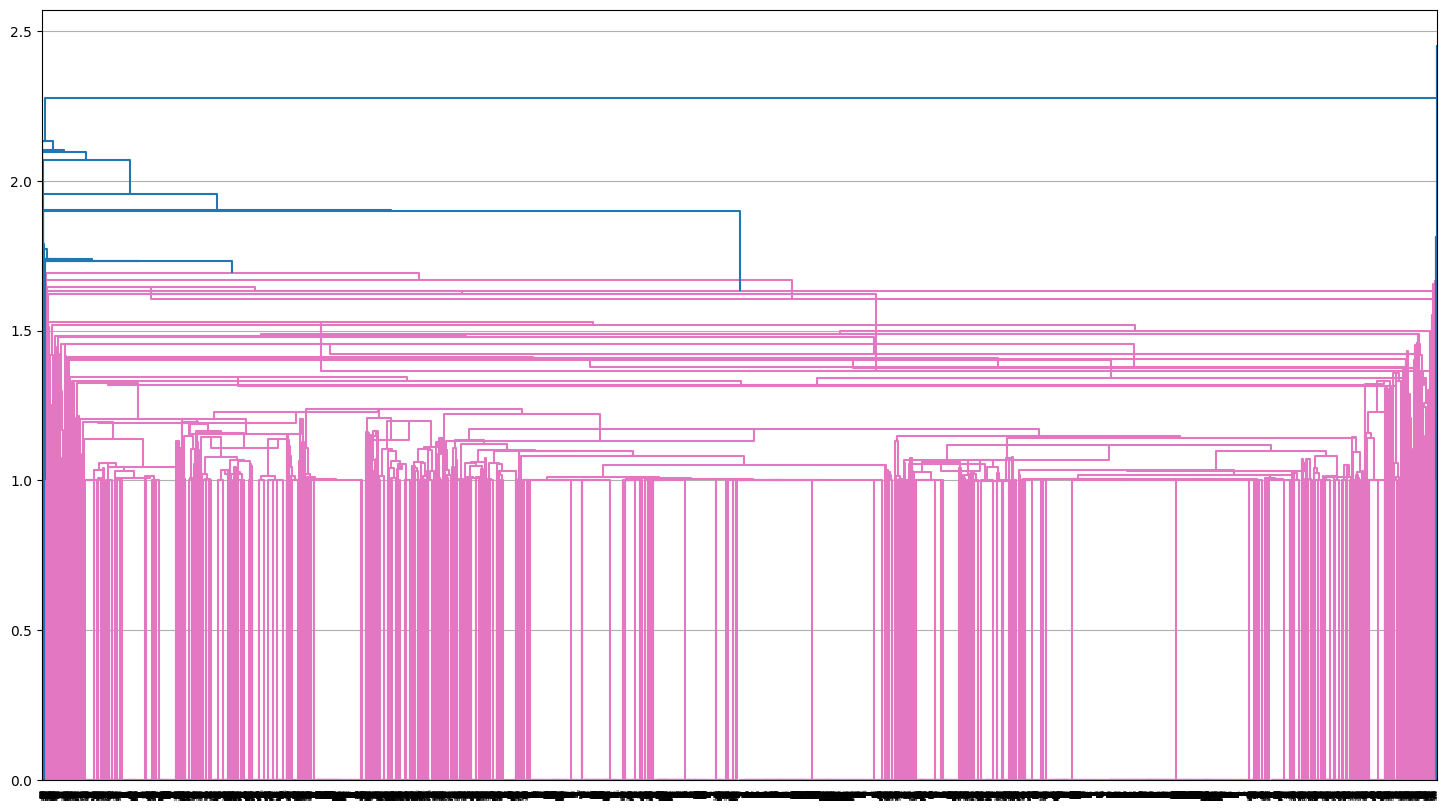

In [ ]:
Z = linkage(movies, 'centroid')
plt.figure(figsize=(18, 10))
plt.grid(axis='y')
dn = dendrogram(Z, labels=list(movies.index), leaf_font_size=2)

Analisando os dendrogramas, parece razoável usar o método "ward", pois foi o que melhor separou os clusters. Além disso, algo entre 5 e 15 clusters visualmente nos parece o ideial.\
Usando o índice de Davies-Bouldin, podemos escolher o melhor k

In [ ]:
metricas = []
for k in range(5,16):
    cluster = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    cluster.fit_predict(movies)  #print clusters
    metricas.append([
        k,
        metrics.davies_bouldin_score(movies,cluster.labels_)
    ])
metricas = pd.DataFrame(metricas)
metricas.columns = ['k', 'Davies-Bouldin']
metricas

,k,Davies-Bouldin
0,5,2.257440
1,6,2.103734
2,7,1.910649
3,8,1.885139
4,9,1.871499
5,10,1.959433
6,11,1.946853
7,12,2.011912
8,13,1.948018
9,14,1.895664


Sendo assim, k=9 parece ser um bom número de clusters

In [ ]:
cluster = AgglomerativeClustering(n_clusters=9, linkage='ward')
groups = cluster.fit_predict(movies)

###**Tratamento dos clusters**

Vamos então adicionar uma nova coluna ao dataframe de filmes indicando o grupo ao qual ele pertence

In [ ]:
movies = df_movies.copy()
movies = movies.drop(['genres'], axis=1)
movies['group'] = groups
movies.head()

,movieId,title,group
0,1,Toy Story (1995),7
1,2,Jumanji (1995),5
2,3,Grumpier Old Men (1995),3
3,4,Waiting to Exhale (1995),3
4,5,Father of the Bride Part II (1995),0


Agora podemos criar a coluna indicadora do grupo no dataframe de ratings


In [ ]:
ratings = df_ratings.drop(['timestamp'], axis=1)
ratings = ratings.merge(movies[['movieId', 'group']], on='movieId', how='left')
ratings

,userId,movieId,rating,group
0,1,1,4.0,7
1,1,3,4.0,3
2,1,6,4.0,2
3,1,47,5.0,2
4,1,50,5.0,2
...,...,...,...,...
100831,610,166534,4.0,4
100832,610,168248,5.0,2
100833,610,168250,5.0,4
100834,610,168252,5.0,8


Selecionamos no dataframe de ratings apenas as notas dadas pelo usuário selecionado, em seguida, podemos calcular a nota média data por esse usuário para cada grupo de filme

In [ ]:
df_user = ratings[ratings['userId'] == user]
df_user_rating = df_user[['userId', 'rating', 'group']].groupby(['group']).mean()
df_user_rating

,userId,rating
group,,
0,599.0,2.404306
1,599.0,2.857692
2,599.0,2.751599
3,599.0,2.680000
4,599.0,2.355140
5,599.0,2.632616
6,599.0,3.081633
7,599.0,2.508197
8,599.0,2.833333


Assim, pegamos o grupo que o usuário classificou com a maior nota média

In [ ]:
group_id = df_user_rating.idxmax()['rating']
print(f'Grupo com a maior nota média: {group_id}')

Grupo com a maior nota média: 6


Filtramos o dataframe de filme para pegar apenas os filmes pertencentes ao grupo favorito do usuário

In [ ]:
movies_group = movies[movies['group'] == group_id]
movies_group.head()

,movieId,title,group
69,77,Nico Icon (1995),6
87,99,Heidi Fleiss: Hollywood Madam (1995),6
96,108,Catwalk (1996),6
101,116,Anne Frank Remembered (1995),6
110,128,Jupiter's Wife (1994),6


Agora podemos pegar o dataframe dos filmes desse grupo e adicionar uma coluna com a nota média de cada filme e outra coluna indicando se o filme já foi assistido ou não

In [ ]:
ratings_movies = ratings[['movieId', 'rating']].groupby('movieId').mean()
ratings_movies = movies_group.merge(ratings_movies, on='movieId', how='left')
ratings_movies['viewed'] = ratings_movies['movieId'].isin(df_user['movieId'])
ratings_movies = ratings_movies.sort_values('rating', ascending=False)
ratings_movies.head()

,movieId,title,group,rating,viewed
125,7096,Rivers and Tides (2001),6,5.0,False
365,152711,Who Killed Chea Vichea? (2010),6,5.0,False
24,1310,Hype! (1996),6,5.0,False
152,26366,Harlan County U.S.A. (1976),6,5.0,False
83,5513,Martin Lawrence Live: Runteldat (2002),6,5.0,False


Para filtragem posterior, vamos adicionar uma nova coluna ao dataframe indicando quantas vezes cada filme foi avaliado

In [ ]:
def get_views(row):
  if row['movieId'] in list(df_ratings['movieId']):
    return df_ratings['movieId'].value_counts()[row['movieId']]
  return 0
ratings_movies['rated'] = ratings_movies.apply(get_views, axis=1)

Dessa forma, podemos primeiramente filtrar apenas os filmes que não foram assistidos pelo usuário e dentre esses, buscar os que foram avaliados ao menos 10 vezes e ordenar por nota

In [ ]:
movies_not_viewed = ratings_movies[~(ratings_movies['viewed'])]
movies_not_viewed = movies_not_viewed[movies_not_viewed['rated'] >= 10]
recommended_movies = movies_not_viewed.sort_values('rating', ascending=False)
recommended_movies = recommended_movies.head(5)
recommended_movies

,movieId,title,group,rating,viewed,rated
8,246,Hoop Dreams (1994),6,4.293103,False,29
265,80906,Inside Job (2010),6,4.291667,False,12
6,162,Crumb (1994),6,4.205882,False,17
102,6331,Spellbound (2002),6,3.923077,False,13
163,27846,"Corporation, The (2003)",6,3.900000,False,10


Dado que temos uma lista dos filmes do grupo favorito do usuário, que ainda não foram assistindos e que tem nota máxima no grupo, podemos recomendar um desses filmes

In [ ]:
print(f'Filme recomendado: {recommended_movies.sample()["title"].iloc[0]}')

## **Comparação entre os modelos e Conclusões**


Para os modelos de classificação baseados em árvores de decisão nota-se que todas as métricas foram boas. Porém o que se destacou foi o Random Forest por ser mais preciso e acurado que os anteriores como mostra a tabela a seguir.

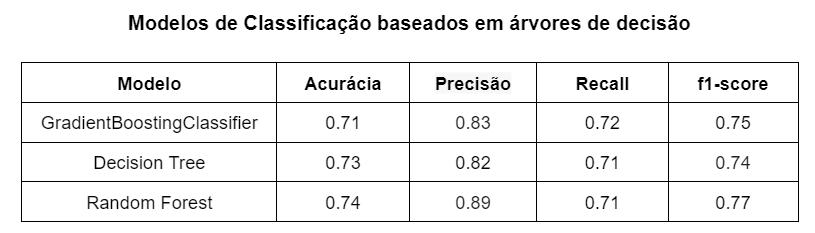

Para os modelos de recomendação usando filtragem colaborativa, usamos outras métricas que melhor se enquadravam para esses estudo. Com isso, é possivel concluir que o modelo de filtragem colaborativa baseada no usuário se mostrou o mais indicado para a recomendação, possuindo menor erro quadrático médio e erro absoluto médio.

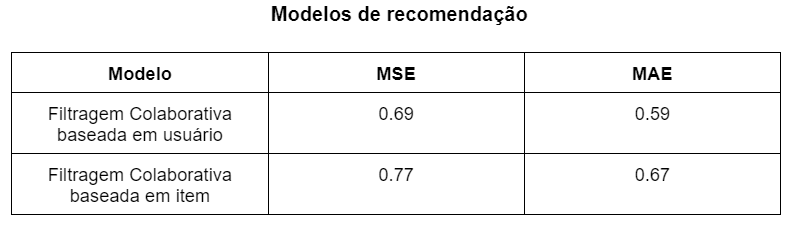

Além disso, faz necessário algumas observações, para se ter um modelo mais preciso e desenvolver um teste para verificar a eficiência de tais recomendações precisaríamos de mais dados e usuários avaliando as recomendações dadas e por fim verificando se atendem às suas expectativas. Um teste A\B para esses casos seria o ideal. Ademais, é possível notar as limitações nas categorizações dos filmes limitadas a base, por exemplo, se um usuário digitar um filme que não existe na base então não teremos uma recomendação para tal, fazendo-se necessário para estudos futuros, uma forma de retroalimentar nosso catálogo com filmes novos.